## Generating Dataset
Let's create the toy dataset. We'll have a 1 16x16 image with a 4x4 square placed somewhere inside.

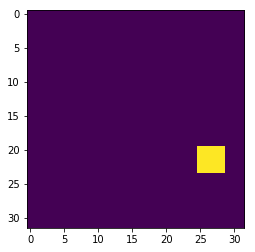

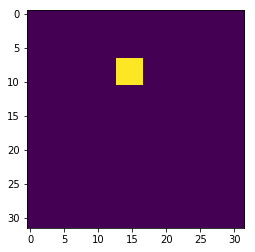

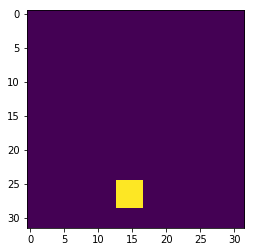

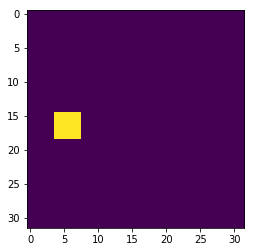

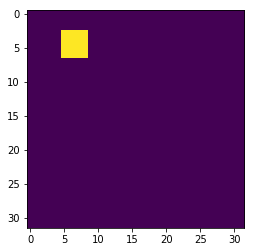

In [29]:
import numpy as np
import matplotlib.pyplot as plt

for i in xrange(5):

    img = np.zeros((1,3,32,32), dtype=np.float32)
    pos_r = np.random.randint(0, img.shape[2]-4-1)
    pos_c = np.random.randint(0, img.shape[3]-4-1)
    img[0,:,pos_r:pos_r+4,pos_c:pos_c+4]=1
    plt.imshow(img[0,0,:,:])
    plt.show()

## Generating Feature maps
Now that we have the image, we'll go over it one by one and generate feature maps of size 4x4.

In [70]:
from chainer import Chain
import chainer
import chainer.functions as F
import chainer.links as L

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__(
            l1=L.Convolution2D(None,32,ksize=(3,3),stride=1,pad=1),
            l2=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l3=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.max_pooling_2d(h1, 2)
        h3 = F.relu(self.l2(h2))
        h4 = F.max_pooling_2d(h3, 2)
        h5 = F.relu(self.l3(h4))
        h6 = F.max_pooling_2d(h5, 2)
        return self.l3(F.sigmoid(h6))

## Linear Convolution to generate shifts

In [74]:
class BoxNet(Chain):
    def __init__(self):
        super(BoxNet, self).__init__(
            l1=L.Convolution2D(None,6,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = self.l1(x)
        return h1
    
convnet = ConvNet()
boxnet = BoxNet()
fm = convnet(img)
shifts = boxnet(fm)
print(output)

variable([[[[-0.01132645 -0.25303978 -0.22416431 -0.23044629]
            [ 0.58845299  0.13366783 -0.12123013 -0.29083633]
            [ 0.46195999  0.09397556 -0.06542507 -0.20067298]
            [ 0.3226462   0.13753761 -0.02673776 -0.09327227]]

           [[ 0.2710543   0.51572108  0.37952605  0.24136785]
            [ 0.26503214  0.16012637  0.12435099  0.03920377]
            [ 0.23452768 -0.17853735 -0.18244636 -0.34492147]
            [ 0.04638854 -0.35323668 -0.21105537 -0.31223714]]

           [[ 0.26346633  0.18129471  0.00375336 -0.19129226]
            [ 0.14781675  0.08322529  0.07135241 -0.01349947]
            [ 0.18261363  0.28556848  0.15135224 -0.02083891]
            [ 0.02119843 -0.01249201 -0.01844944 -0.04112962]]

           [[ 0.0185515  -0.24254642 -0.27667865 -0.18742724]
            [ 0.20277523 -0.09825141 -0.08822567 -0.20940785]
            [ 0.47817242  0.10051882  0.20033857 -0.13496475]
            [ 0.41054383  0.31215805  0.38353115  0.03767049]]



## Draw generated default boxes on top of the original image

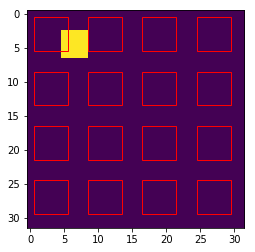

(19.0, 3.0, 5.0, 5.0, 0.0, 0.0)

In [119]:
from matplotlib import patches

# Function to generate default boxes
def defaultgen( I, F, width, height): 
    """
    Generates an array of default boxes: TESTED
    
    Args:
        I: Input image tensor (N,channels,rows,cols)
        F: Feature map tensor to generate default boxes for
        width: Width of the box
        height: Height of the box
        
    Returns:
        db: Default boxes tensor, flattened
    """
    boxes = np.zeros((F.shape[2], F.shape[3], 6))
    scale = (I.shape[2]/ F.shape[2])
    
    for i in range(F.shape[2]): 
        for j in range(F.shape[3]): 
            
            # d depends on the number of max pooling layers
            cx  = ((( scale- 1)/ 2 )+ (j*(scale )))
            cy  = (((scale - 1)/ 2 )+ (i*(scale ))) 
            
            boxes[i,j,:] = np.array([cx,cy,width, height, 0, 0])
            
    return boxes.reshape(F.shape[2] * F.shape[3], 6)

def center_to_coords(box):
    """ 
    Converts bounding box from (cx, cy, w, h) format to (x1, y1, x2, y2) format
    
    Args:
        box: 6d numpy array
        
    Returns:
        box_transformed: Box in the second format
    
    """
    box_transformed = np.array([box[0]-box[2]/2.0, box[1]+box[3]/2.0, box[0]+box[2]/2.0, box[1]-box[3]/2.0, box[4], box[5]])
    return box_transformed


def draw_boxes(img, boxes):
    plt.figure()
    ax = plt.axes()

    for box in boxes:
        box = center_to_coords(box)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red')
        ax.add_patch(p)

    plt.show()

def_boxes = defaultgen(img, fm, 5,5)
def_boxes[0][2:4]
draw_boxes(img, def_boxes)
tuple(def_boxes[2])

## Draw predictions on top of the original image
Now with the shift tensor we have obtained from running convnet and boxnet together, let's offset the default boxes.

In [128]:
shifts.shape

shifts.reshape(1,4*4,6)

variable([[[ 0.24698617,  0.0577729 , -0.01022299, -0.12986304,
             0.07537354, -0.15442716],
           [-0.2618534 , -0.35989481, -0.1499566 , -0.29884976,
            -0.4064233 , -0.29353878],
           [-0.10556263, -0.37198743, -0.42026427, -0.31644922,
            -0.28402373, -0.09043977],
           [-0.04924194,  0.31574908, -0.33826223,  0.08958955,
             0.16340928,  0.59542888],
           [-0.32630366,  0.03036014,  0.16529712,  0.53242725,
            -0.3412348 ,  0.07370429],
           [ 0.16847478,  0.43294001, -0.11857632, -0.09325638,
             0.01961319,  0.08932865],
           [ 0.06642763,  0.07867718,  0.27832726,  0.19628142,
             0.1880039 ,  0.16369925],
           [ 0.36590916,  0.18132144,  0.26822266,  0.32182267,
             0.39074361,  0.24331219],
           [-0.34526977, -0.40843284, -0.63753051, -0.39764518,
            -0.2129548 , -0.22069632],
           [-0.27164257, -0.04484848,  0.10241784,  0.38243464,
         

## Do matching

## Compute classification loss (brute force for loop cpu)

## Compute regression loss (brute force for loop cpu)